In [11]:
###This code creates the configuration so that changing parameters for training are easier
class config:
    epochs = 10
    batch_size = 32
    valid_batch_size = 64
    model_name = "roberta-large"
    num_workers = 2
    folds = 5
    current_fold = 1
    max_len = 100
    seed = 2022
    debug = False

In [2]:
###Import necessary libraries, set environment variables, and install transformers
!pip install transformers
from transformers import Trainer, AutoModel, AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW
from IPython.display import display
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, average_precision_score, recall_score, f1_score
import pandas as pd
import time
import numpy as np
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [3]:
###Creates a function to convert labels to ints
conv_dict = {
    "positive" : 0,
    "neutral" : 1,
    "negative" : 2
}

def Int2Label(int_cls):
    return conv_dict[int_cls]

In [4]:
###Reads the training file, counts the number of words in each tweet, so as to have an idea of what to set max_len to
###Also converts each sentiment into integers
data = pd.read_csv("../input/financial-sentiment-analysis/data.csv")
data["tokens"] = data["Sentence"].apply(str.split)
data["word_counts"] = data["tokens"].apply(len)
data["targets"] = data["Sentiment"].apply(Int2Label)
display(data)

,Sentence,Sentiment,tokens,word_counts,targets
0,The GeoSolutions technology will leverage Bene...,positive,"[The, GeoSolutions, technology, will, leverage...",32,0
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,"[$ESI, on, lows,, down, $1.50, to, $2.50, BK, ...",11,2
2,"For the last quarter of 2010 , Componenta 's n...",positive,"[For, the, last, quarter, of, 2010, ,, Compone...",39,0
3,According to the Finnish-Russian Chamber of Co...,neutral,"[According, to, the, Finnish-Russian, Chamber,...",20,1
4,The Swedish buyout firm has sold its remaining...,neutral,"[The, Swedish, buyout, firm, has, sold, its, r...",23,1
...,...,...,...,...,...
5837,RISING costs have forced packaging producer Hu...,negative,"[RISING, costs, have, forced, packaging, produ...",17,2
5838,Nordic Walking was first used as a summer trai...,neutral,"[Nordic, Walking, was, first, used, as, a, sum...",14,1
5839,"According shipping company Viking Line , the E...",neutral,"[According, shipping, company, Viking, Line, ,...",16,1
5840,"In the building and home improvement trade , s...",neutral,"[In, the, building, and, home, improvement, tr...",18,1


<AxesSubplot:>

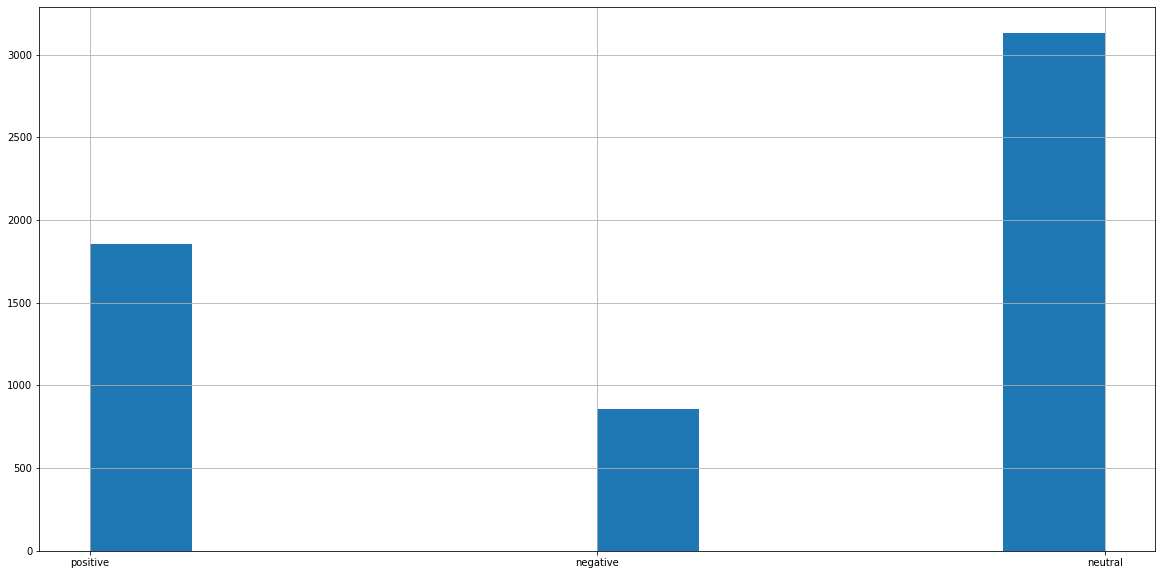

In [5]:
###Visualizes the number of tweets with each sentiment
display(data["Sentiment"].hist(figsize=(20, 10)))

<AxesSubplot:>

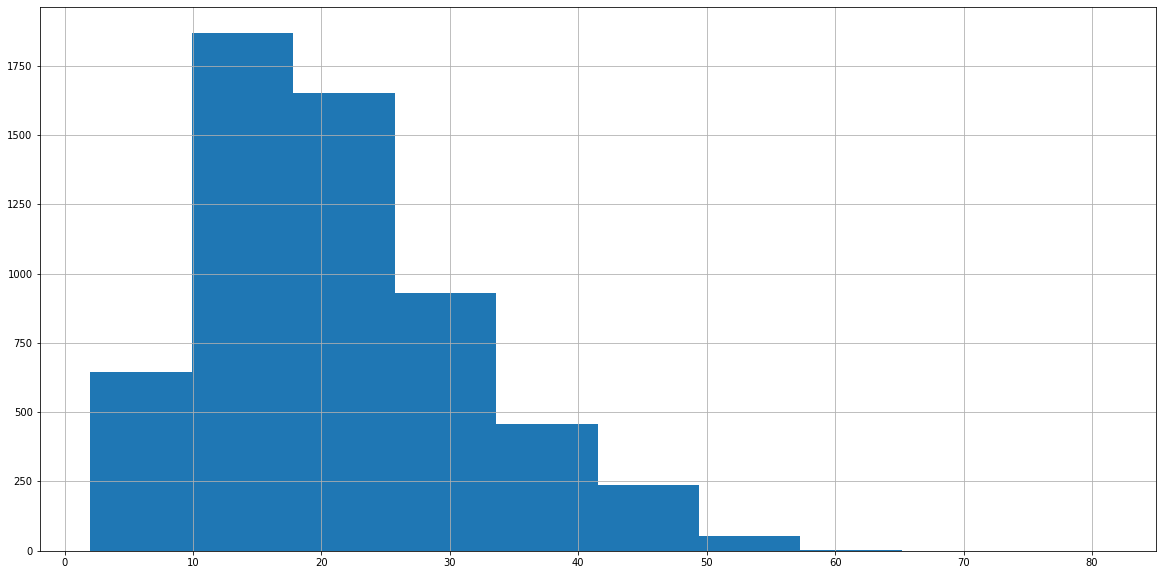

In [6]:
###Visualizes word counts across all tweets
display(data["word_counts"].hist(figsize=(20, 10)))

In [7]:
###We take the tweets and processed labels from the dataframe. If we are debugging, we only consider the first 50 of each
texts = data["Sentence"].values
targets = data["targets"]
if config.debug:
    texts = texts[:50]
    targets = targets[:50]
    data = data[:50]

In [8]:
###We use the cross validation method to train our model. However, due to unnecessary additional complexity, we 
###only consider the first fold. We divide the data into 80% for training, and 20% for validation. 
kf = StratifiedKFold(shuffle=True, random_state=config.seed, n_splits=config.folds)

for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(data, targets)):
    if fold_idx+1 == config.current_fold:
        train_texts, valid_texts =  texts[train_idx], texts[valid_idx]
        train_targets, valid_targets = targets.iloc[train_idx], targets.iloc[valid_idx]

In [9]:
###Creates the pytorch dataset
class FinanceSentimentAnalysisDataset(Dataset):
    def __init__(self, texts, targets, tokenizer):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokenized_inputs = self.tokenizer(text, max_length=config.max_len, truncation=True, padding="max_length", is_split_into_words=False)
        tokenized_inputs["input_ids"] = torch.tensor(tokenized_inputs["input_ids"])
        tokenized_inputs["attention_mask"] = torch.tensor(tokenized_inputs["attention_mask"])
        tokenized_inputs["target"] = self.targets[idx]
        return tokenized_inputs

In [12]:
###This code loads the pretrained roberta tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
model = AutoModelForSequenceClassification.from_pretrained(config.model_name, num_labels=3).cuda()

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifie

In [13]:
###This code creates two datasets, one for training and one for validation
###It also prepares the dataloaders, so we can efficiently serve the model the data
train_dataset = FinanceSentimentAnalysisDataset(train_texts, train_targets.values, tokenizer)
train_dataloader = DataLoader(train_dataset, shuffle=True, num_workers=config.num_workers, batch_size=config.batch_size)
valid_dataset = FinanceSentimentAnalysisDataset(valid_texts, valid_targets.values, tokenizer)
valid_dataloader = DataLoader(valid_dataset, shuffle=True, num_workers=config.num_workers, batch_size=config.valid_batch_size)

In [14]:
###This function is designed to see how well the model does on the validation data. 
###It computes the accuracy, and loss of the model
def ValidateModel(model, dataloader, loss_fn, epoch):
    total_loss = 0 
    total_precision = 0
    total_f1 = 0
    total_acc = 0
    for example in dataloader:
        with torch.no_grad():
            example["input_ids"] = example["input_ids"].cuda()
            example["attention_mask"] = example["attention_mask"].cuda()
            output = model(example["input_ids"], example["attention_mask"], labels=example["target"].cuda())
            class_preds = torch.argmax(output.logits, -1).detach().cpu().numpy()
  
        total_loss += output.loss
        total_acc += accuracy_score(np.array(example["target"]), class_preds)
        total_f1 += f1_score(np.array(example["target"]), class_preds, average="macro")
    print(f"Epoch: {epoch} | Loss: {total_loss/len(dataloader)} | Accuracy : {total_acc/len(dataloader)} | F1 Score: {total_f1/len(dataloader)}")

In [15]:
###This function trains the model, calculating the loss for its predictions and adjusting its weights accordingly
def Train(model, dataloader, valid_dataloader, loss_fn, optimizer):
    start = time.time()
    for epoch in range(config.epochs):
        for batch_idx, (example) in enumerate(dataloader):
            optimizer.zero_grad()
            example["input_ids"] = example["input_ids"].cuda()
            example["attention_mask"] = example["attention_mask"].cuda()
            output = model(example["input_ids"], example["attention_mask"], labels=example["target"].cuda())
            class_preds = torch.argmax(output.logits, -1)
            loss = output.loss

            loss.backward()
            optimizer.step()
    
        ValidateModel(model, valid_dataloader, loss_fn, epoch+1)
        torch.save(model.state_dict(), f"fold{config.current_fold}_model{config.model_name}_epoch{epoch+1}.pth")
    end = time.time()
    print(f"Elapsed Time: {end-start}")

In [16]:
###Defines the loss we are using, and the optimizer algorithm
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-6)

In [17]:
###Trains it and saves the model files for each epoch
Train(model, train_dataloader, valid_dataloader, loss_fn, optimizer)

Epoch: 1 | Loss: 0.9107598066329956 | Accuracy : 0.5662732198142415 | F1 Score: 0.31252163617371326
Epoch: 2 | Loss: 0.8115530610084534 | Accuracy : 0.6395123839009288 | F1 Score: 0.4380167322713831
Epoch: 3 | Loss: 0.6741118431091309 | Accuracy : 0.7203463622291022 | F1 Score: 0.5889764563723924
Epoch: 4 | Loss: 0.4172007441520691 | Accuracy : 0.8046633126934984 | F1 Score: 0.7450603198456512
Epoch: 5 | Loss: 0.3767414689064026 | Accuracy : 0.8155476006191951 | F1 Score: 0.71906447738604
Epoch: 6 | Loss: 0.35987696051597595 | Accuracy : 0.8200948142414861 | F1 Score: 0.7646902517049569
Epoch: 7 | Loss: 0.37619641423225403 | Accuracy : 0.8025832043343654 | F1 Score: 0.7357851740875381
Epoch: 8 | Loss: 0.4043532907962799 | Accuracy : 0.8097910216718267 | F1 Score: 0.7685903681518288
Epoch: 9 | Loss: 0.4070001542568207 | Accuracy : 0.8196594427244582 | F1 Score: 0.7174013978837804
Epoch: 10 | Loss: 0.4032026529312134 | Accuracy : 0.8005514705882353 | F1 Score: 0.7598564048096228
Elapsed 